In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import glob
import cv2
#import seaborn as sns
%matplotlib inline

In [2]:
from opmap.RawCam import RawCam
from opmap.VmemMap import VmemMap
from opmap.PhaseMap import PhaseMap
from opmap.PhaseVarianceMap import PhaseVarianceMap
from opmap.util import makeMovie

In [3]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

# 熱拡散を用いた冷却実験の結果確認

In [ ]:
vmem = RawCam('/mnt/recordings/SimulationResults/20171028-1/', cam_type='numpy',
             image_height=200, image_width=200, frame_start=0, frame_end=-1)

In [ ]:
vmem_temp = VmemMap(vmem)
vmem.cmap = vmem_temp.cmap

In [ ]:
vmem.saveImage('/mnt/recordings/AnalysisResult/Seno/simulation/Mahajan/20171030/20171028-1')

In [ ]:
subprocess.call('ffmpeg -r 30 -y -i "/mnt/recordings/AnalysisResult/Seno/simulation/Mahajan/20171030/20171028-1/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "/mnt/recordings/AnalysisResult/Seno/simulation/Mahajan/20171030/vmem.mp4"', shell=True)

In [ ]:
a = np.load('/mnt/recordings/SimulationResults/20171028-1/cell_8000/temp.npy')

In [ ]:
plt.imshow(a.reshape((200, 200)), cmap='jet')
plt.colorbar()

# 興奮前面・後面解析

In [4]:
out_dir = '/mnt/recordings/AnalysisResult/Seno/simulation/Mahajan/20171031'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [ ]:
dir_name = '20171014-40'
time = 1000
hj_array = np.zeros((time+1, 200, 200))
m_array = np.zeros((time+1, 200, 200))
Ina = np.zeros((time+1, 200, 200))
for i in range(time):
    num = '{0:04d}'.format(i)
    a = np.load('/mnt/recordings/SimulationResults/%s/cell_%s/%s' % (dir_name, num, 'h.npy')).reshape((200, 200))
    b = np.load('/mnt/recordings/SimulationResults/%s/cell_%s/%s' % (dir_name, num, 'j.npy')).reshape((200, 200))
    hj_array[i, :, :] = a*b
    m_array[i, :, :] = np.load('/mnt/recordings/SimulationResults/%s/cell_%s/%s' % (dir_name, num, 'm.npy')).reshape((200, 200))
    Ina[i, :, :] = np.load('/mnt/recordings/SimulationResults/%s/cell_%s/%s' % (dir_name, num, 'xina.npy')).reshape((200, 200))

## 興奮前面 & 興奮後面(hj)マップ & 位相分散マップ

In [ ]:
vmem = RawCam('/mnt/recordings/SimulationResults/20171014-40/', cam_type='numpy',
             image_height=200, image_width=200, frame_start=0, frame_end=300)
vmem = VmemMap(vmem)
phase = PhaseMap(vmem, shrink=2)
phase_variance = PhaseVarianceMap(phase, size=3)

for i in range(200):
    num = "{0:04d}".format(i)
    plt.imshow(hj_array[i], vmin=np.min(hj_array), vmax=np.max(hj_array))
    plt.xticks([])
    plt.yticks([])
    plt.savefig('/mnt/recordings/AnalysisResult/Seno/simulation/Mahajan/20171031/20171014-40/hj/%s.png'%num, dpi=300)
    plt.close()
    
    plt.imshow((np.sum((Ina[i-width:i, :, :] < -1), axis=0) > 0), vmin=0, vmax=1, cmap='Reds')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('/mnt/recordings/AnalysisResult/Seno/simulation/Mahajan/20171031/20171014-40/ina/%s.png'%num, dpi=300)
    plt.close()
    
    plt.imshow((phase_variance.data[i] > 0.4), vmin=0, vmax=1, cmap='Reds')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('/mnt/recordings/AnalysisResult/Seno/simulation/Mahajan/20171031/20171014-40/pvmap/%s.png'%num, dpi=300, transparent=True)
    plt.close()

## 全画像をブレンド

### rとbが入れ替わっている。白は255

In [64]:
hj = cv2.cvtColor(cv2.imread(os.path.join(out_dir, '20171014-40/hj/0100.png')), cv2.COLOR_BGR2RGB)
ina = cv2.cvtColor(cv2.imread(os.path.join(out_dir, '20171014-40/ina/0100.png')), cv2.COLOR_BGR2RGB)
pvmap = cv2.cvtColor(cv2.imread(os.path.join(out_dir, '20171014-40/pvmap/0080.png')), cv2.COLOR_BGR2RGB)

In [65]:
ina_threshold = (ina[:, :, 2] < 128) * (ina[:, :, 2] > 3) * 1
center = (pvmap[:, :, 2] < 128) * (pvmap[:, :, 2] > 3) * 1

In [66]:
data = np.zeros_like(hj)
data[:, :, 0] = ina_threshold*255+(1-ina_threshold)*hj[:, :, 0]
data[:, :, 1] = (1-ina_threshold)*hj[:, :, 1]
data[:, :, 2] = (1-ina_threshold)*hj[:, :, 2]

data[:, :, 0] = center*255+(1-center)*data[:, :, 0]
data[:, :, 1] = center*255+(1-center)*data[:, :, 1]
data[:, :, 2] = center*255+(1-center)*data[:, :, 2]

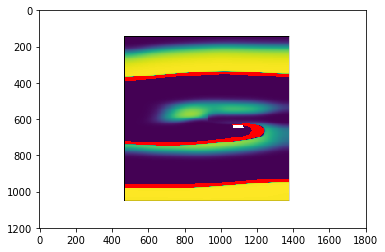

In [67]:
plt.imshow(data)

In [74]:
pv_lag = 22
for i in range(200):
    if i < pv_lag:
        pass
    else:
        num = "{0:04d}".format(i)
        pv_num = "{0:04d}".format(i-pv_lag)
        hj = cv2.cvtColor(cv2.imread(os.path.join(out_dir, '20171014-40/hj/%s.png'%num)), cv2.COLOR_BGR2RGB)
        ina = cv2.cvtColor(cv2.imread(os.path.join(out_dir, '20171014-40/ina/%s.png'%num)), cv2.COLOR_BGR2RGB)
        pvmap = cv2.cvtColor(cv2.imread(os.path.join(out_dir, '20171014-40/pvmap/%s.png'%pv_num)), cv2.COLOR_BGR2RGB)
        
        ina_threshold = (ina[:, :, 2] < 128) * (ina[:, :, 2] > 3) * 1
        center = (pvmap[:, :, 2] < 128) * (pvmap[:, :, 2] > 3) * 1
        
        data = np.zeros_like(hj)
        data[:, :, 0] = ina_threshold*255+(1-ina_threshold)*hj[:, :, 0]
        data[:, :, 1] = (1-ina_threshold)*hj[:, :, 1]
        data[:, :, 2] = (1-ina_threshold)*hj[:, :, 2]

        data[:, :, 0] = center*255+(1-center)*data[:, :, 0]
        data[:, :, 1] = center*255+(1-center)*data[:, :, 1]
        data[:, :, 2] = center*255+(1-center)*data[:, :, 2]
        
        plt.imshow(data)
        plt.xticks([])
        plt.yticks([])
        plt.savefig(os.path.join(out_dir, '20171014-40/integrate/%s.png'%pv_num), dpi=300)
        plt.close()